In [145]:
import torch
from sklearn.cluster import KMeans

import plotly.figure_factory as ff
import plotly.express as px

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import geopandas as gpd

import pickle
import h3
import pandas as pd
import numpy as np
import ast

# Data

## Polyline data and H3 sequences

In [104]:
data_with_h3 = pd.read_csv("../data/data_with_h3.csv")

In [105]:
with open("../models/tokenizers/decode_token_to_h3.pickle", "rb") as f:
    token_to_h3 = pickle.load(f)

## H3 Embeddings

In [106]:
loc2vec = torch.load("../models/embeddings/loc2vec_100k_9_28")
embeddings = loc2vec["target_embed.weight"]

## Portugal Polygon

In [107]:
gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf = gdf[gdf["name"]=="Portugal"]
portugal_polygon = gdf.iloc[0, 5]

# Filtering Out Points not in Portugal

In [126]:
geolocs = []
h3_ids = list(token_to_h3.values())
for h3_id in h3_ids:
    geo = h3.h3_to_geo(h3_id)
    geolocs.append(geo)
h3_df = pd.DataFrame(geolocs, columns=["long", "lat"])
len(h3_df)

4047

In [127]:
points_in_portugal = []
for row in h3_df.iterrows():
    lat = row[1]["lat"]
    long = row[1]["long"]
    point = Point(long, lat)
    if portugal_polygon.contains(point):
        h3_id = h3.geo_to_h3(lat, long, 7)
        points_in_portugal.append((h3_id, lat, long))
len(h3_df)

4047

In [130]:
h3_df = pd.DataFrame(points_in_portugal, columns=["h3", "lat", "long"])
h3_df.to_csv("../data/embedded_h3_and_lat_lon.csv", index=False)
h3_df.head()

,h3,lat,long
0,8739220f0ffffff,41.151489,-8.619378
1,8739220f6ffffff,41.139793,-8.639436
2,8739220f4ffffff,41.163080,-8.639906
3,8739220f6ffffff,41.151385,-8.659966
4,87392201affffff,41.174672,-8.660434


In [146]:
X = embeddings.numpy()

In [161]:
scores = []
for n_clust in range(1000, 1500):
    kmeans = KMeans(n_clusters=8).fit(X)
    sse = kmeans.score(X)
    scores.append(sse)

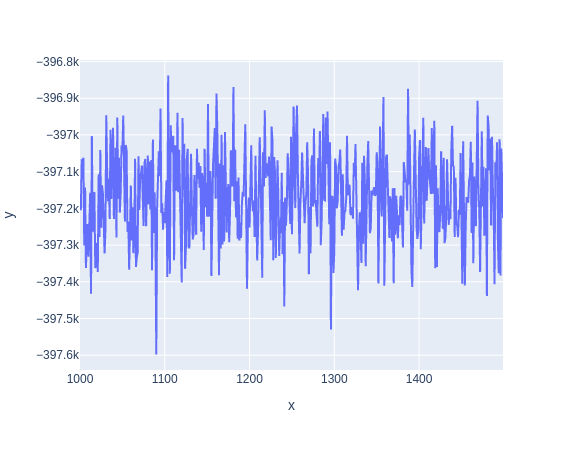

In [163]:
fig = px.line(x = range(1000, 1500), y=scores)
fig.show()